
<h1 class="notebook-title"> Using Packet Rate Data to Detect Ongoing DoS Attacks </h1>

In this notebook, we look to examine data on packets collected from vSocial, a Virtual Reality Learning Environment, during periods of normal activity along with samples collected during simulated DoS attacks (packet duplication, tampering, and dropping attacks). We first organize and restructure the data to get necessary statistics such as total packets sent over time and changes in packet speed over time, and we plot these measurements to compare discrepencies between each of the behaviors (normal vs. various DoS attacks). The final goal is to develop a detection algorithm that accurately classifies whether the current packet data implies normal behavior or the ongoing activities of one of the attacks. We use time series feature extraction to discover quantitative parameters from samples of packet speed over a period of time, and then are able to train various supervised machine learning models to attempt to classify a given situation. A variety of models are tested and compared for accuracy, and the most successful models for us were found to be implementations of K Nearest Neighbors, Random Forests, and a Voting Classifier combining the use of both.

<div class="outline">

----------------------------- Notebook Outline -----------------------------

<ul> 
    <br>

    <li>
        <a href="#Libraries">Libraries</a>
    </li>
    
    <br>
    
    <li>
        <a href="#Data">Data</a>
        <ul>
          <li><a href="#Data-a">A. Normal Behavior</a></li>
          <li><a href="#Data-b">B. Duplication Attack</a></li>
          <li><a href="#Data-c">C. Tampering Attack</a></li>
          <li><a href="#Data-d">D. Dropping Attack</a></li>
        </ul>
    </li>

    <br>
    
    <li>
        <a href="#Visualizations">Visualizations</a>
        <ul>
          <li>
              <a href="#Visualizations-a">A. Total Packets Sent Over Time</a>
              <ul>
                  <li><a href="#Visualizations-a-i">i. Normal Behavior</a></li>
                  <li><a href="#Visualizations-a-ii">ii. Duplication Attack</a></li>
                  <li><a href="#Visualizations-a-iii">iii. Tampering Attack</a></li>
                  <li><a href="#Visualizations-a-iv">iv. Dropping Attack</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Visualizations-b">B. Packet Rate Changes Over Time</a>
              <ul>
                  <li><a href="#Visualizations-b-i">i. Normal Behavior</a></li>
                  <li><a href="#Visualizations-b-ii">ii. Duplication Attack</a></li>
                  <li><a href="#Visualizations-b-iii">iii. Tampering Attack</a></li>
                  <li><a href="#Visualizations-b-iv">iv. Dropping Attack</a></li>
              </ul>
          </li>
          <br>
          <li><a href="#Visualizations-c">C. Interactive Plot</a></li>
        </ul>
    </li>
    
    <br>
    
    <li>
        <a href="#Classifiers">Classifiers</a>
        <ul>
          <li>
              <a href="#Classifiers-a">A. Feature Extraction</a>
              <ul>
                  <li><a href="#Classifiers-a-i">i. tsfresh</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Classifiers-b">B. Feature Filtering</a>
              <ul>
                  <li><a href="#Classifiers-b-i">i. tsfresh</a></li>
                  <li><a href="#Classifiers-b-ii">ii. Select K Best</a></li>
                  <li><a href="#Classifiers-b-iii">iii. Principal Component Analysis</a></li>
              </ul>
          </li>
          <br>
          <li>
              <a href="#Classifiers-c">C. Machine Learning Models</a>
              <ul>
                  <li><a href="#Classifiers-c-i">i. Decision Tree</a></li>
                  <li><a href="#Classifiers-c-ii">ii. Multilayer Perceptron (Neural Network)</a></li>
                  <li><a href="#Classifiers-c-iii">iii. SVC</a></li>
                  <li><a href="#Classifiers-c-iv">iv. Logistic Regression</a></li>
                  <li><a href="#Classifiers-c-v">v. K Nearest Neighbors</a></li>
                  <li><a href="#Classifiers-c-vi">vi. Random Forests</a></li>
                  <li><a href="#Classifiers-c-v">v. K Nearest Neighbors + Random Forests Voting</a></li>                  
              </ul>
          </li>
          <br>
        </ul>
    </li>
    
    <li>
        <a href="#Results">Results</a>
        <ul>
          <li>
              <a href="#Results-a">A. Decision Tree</a>
          </li>
          <li>
              <a href="#Results-b">B. K Nearest Neighbors</a>
          </li>
          <li>
              <a href="#Results-c">C. Random Forests</a>
          </li>
          <li>
              <a href="#Results-d">D. K Nearest Neighbors + Random Forests Voting</a>
          </li>
        </ul>
    </li>


</ul>

</div>

<h1 class="section-header"><a id="Libraries"></a>Libraries</h1>

In [250]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as time

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode, plot
init_notebook_mode(connected=True)

import random

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import confusion_matrix
from statistics import mean
from scipy.stats import pearsonr

<h1 class="section-header"><a id="Data"></a>Data</h1>

<h1><a id="Data-a"></a>A. Normal Behavior</h1>

In [251]:
df_norm = pd.read_csv("vSocial_Norm_10mins.csv")
df_norm.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.147,128.206.20.43,UDP,83,64513 > 50495 Len=41
1,2,0.000022,128.206.20.147,128.206.20.43,QUIC,83,Protected Payload (KP0)
2,3,0.000035,128.206.20.147,128.206.20.43,UDP,83,64513 > 50497 Len=41
3,4,0.000048,128.206.20.147,128.206.20.43,UDP,83,64513 > 50496 Len=41
4,5,0.000061,128.206.20.147,128.206.20.43,UDP,83,64513 > 50500 Len=41


<h1><a id="Data-b"></a>B. Duplication Attack</h1>

In [252]:
df_dup = pd.read_csv("vSocial_Dup_10mins.csv")
df_dup.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
1,2,0.000210,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
2,3,0.000577,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
3,4,0.000921,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90
4,5,0.001063,128.206.20.147,128.206.20.43,UDP,132,64513 > 50494 Len=90


<h1><a id="Data-c"></a>C. Tampering Attack</h1>

In [253]:
df_tamper = pd.read_csv("vSocial_Tamper_10mins.csv")
df_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.147,UDP,168,50496 > 64513 Len=126
1,2,0.000567,128.206.20.147,128.206.20.43,UDP,132,64513 > 62430 Len=90
2,3,0.004150,128.206.20.43,128.206.20.147,UDP,82,62430 > 64513 Len=40
3,4,0.004866,128.206.20.147,128.206.20.43,UDP,610,64513 > 50496 Len=568
4,5,0.010442,128.206.20.147,128.206.20.43,UDP,132,64513 > 62430 Len=90


<h1><a id="Data-d"></a>D. Dropping Attack</h1>

In [254]:
df_drop = pd.read_csv("vSocial_Drop_10mins.csv")
df_drop.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
1,2,0.008214,128.206.20.43,128.206.20.147,UDP,709,50499 > 64513 Len=667
2,3,0.010326,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
3,4,0.023819,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40
4,5,0.030320,128.206.20.43,128.206.20.147,UDP,82,57490 > 64513 Len=40


<h1><a id="Data-e"></a>E. Duplication + Dropping Attack</h1>

In [255]:
df_dup_drop = pd.read_csv("vSocial_Dup_Drop_10mins.csv")
df_dup_drop.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.46,128.206.20.43,UDP,614,58222 > 62057 Len=572
1,2,0.007095,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
2,3,0.012939,128.206.20.43,128.206.20.46,UDP,143,62057 > 58222 Len=101
3,4,0.016943,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
4,5,0.026106,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40


<h1><a id="Data-f"></a>F. Duplication + Tampering Attack</h1>

In [256]:
df_dup_tamper = pd.read_csv("vSocial_Dup_Tamper_10mins.csv")
df_dup_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584
1,2,0.000713,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584
2,3,0.001075,128.206.20.43,128.206.20.46,UDP,198,53291 > 58222 Len=156
3,4,0.001075,128.206.20.43,128.206.20.46,UDP,198,53291 > 58222 Len=156
4,5,0.001196,128.206.20.46,128.206.20.43,UDP,626,58222 > 53290 Len=584


<h1><a id="Data-g"></a>G. Dropping + Tampering Attack</h1>

In [257]:
df_drop_tamper = pd.read_csv("vSocial_Drop_Tamper_10mins.csv")
df_drop_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
1,2,0.002915,128.206.20.46,128.206.20.43,UDP,132,58222 > 62053 Len=90
2,3,0.011434,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40
3,4,0.019637,128.206.20.43,128.206.20.46,UDP,143,62057 > 58222 Len=101
4,5,0.019637,128.206.20.43,128.206.20.46,UDP,82,62053 > 58222 Len=40


<h1><a id="Data-h"></a>H. Dropping + Duplication + Tampering Attack</h1>

In [258]:
df_drop_dup_tamper = pd.read_csv("vSocial_Drop_Dup_Tamper_10mins.csv")
df_drop_dup_tamper.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
1,2,0.009997,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
2,3,0.012511,128.206.20.43,128.206.20.46,UDP,143,63271 > 54854 Len=101
3,4,0.019995,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40
4,5,0.029499,128.206.20.43,128.206.20.46,UDP,82,54179 > 54854 Len=40


<h1 class="section-header"><a id="Visualizations"></a>Visualizations</h1>

In [259]:
def getPacketsSent(df):
    speedArray = []
    for i in range(0, 600):
        speedArray.append(len(df[df.Time <= i+1]))
    return speedArray

In [260]:
def getPacketSpeeds(df):
    speedArray = []
    for i in range(0, 600):
        speedArray.append(len(df[(df.Time >= i) & (df.Time <= i+1)]))
    return speedArray

<h1><a id="Visualizations-a"></a>A. Total Packets Sent Over Time</h1>

<h2><a id="Visualizations-a-i"></a>i. Normal Behavior</h2>

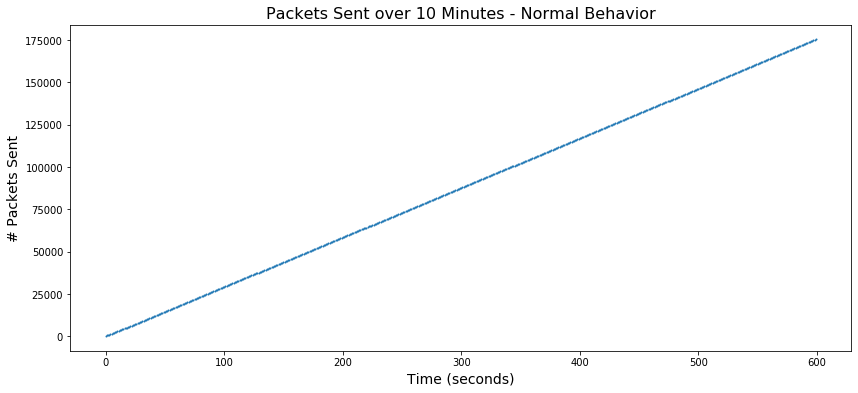

In [261]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_norm), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Normal Behavior", fontsize=16)
plt.show()

In [262]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_norm))]

layout = dict(
    title="Packets Sent over 10 Minutes - Normal Behavior",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

TypeError: 'dict' object is not callable

<h2><a id="Visualizations-a-ii"></a>ii. Duplication Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication Attack", fontsize=16)
plt.show()

In [ ]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_dup))]

layout = dict(
    title="Packets Sent over 10 Minutes - Duplication Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-iii"></a>iii. Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Tampering Attack", fontsize=16)
plt.show()

In [ ]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_tamper))]

layout = dict(
    title="Packets Sent over 10 Minutes - Tampering Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-iv"></a>iv. Dropping Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping Attack", fontsize=16)
plt.show()

In [ ]:
data = [go.Scatter(
          x=np.arange(0, 600),
          y=getPacketsSent(df_drop))]

layout = dict(
    title="Packets Sent over 10 Minutes - Dropping Attack",
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(
            visible = True
        )
    ), 
    yaxis=dict(
        title='# Packets Sent'
    )
)

iplot(dict(data=data, layout=layout))

<h2><a id="Visualizations-a-v"></a>v. Duplication + Dropping Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup_drop), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication + Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-vi"></a>vi. Duplication + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_dup_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Duplication + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-vii"></a>vii. Dropping + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-a-viii"></a>viii. Dropping + Duplication + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.scatter(np.arange(0, 600), getPacketsSent(df_drop_dup_tamper), s=1)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packets Sent over 10 Minutes - Dropping + Duplication + Tampering Attack", fontsize=16)
plt.show()

<h1><a id="Visualizations-b"></a>B. Packet Rate Changes Over Time</h1>

<h2><a id="Visualizations-b-i"></a>i. Normal Behavior</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_norm), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Normal Behavior", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-ii"></a>ii. Duplication Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-iii"></a>iii. Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-iv"></a>iv. Dropping Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-v"></a>v. Duplication + Dropping Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup_drop), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication + Dropping Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-vi"></a>vi. Duplication + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_dup_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Duplication + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-vii"></a>vii. Dropping + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping + Tampering Attack", fontsize=16)
plt.show()

<h2><a id="Visualizations-b-viii"></a>viii. Dropping + Duplication + Tampering Attack</h2>

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(0, 600), getPacketSpeeds(df_drop_dup_tamper), '-')
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("# Packets Sent", fontsize=14)
plt.title("Packet Rate Over 10 Minutes - Dropping + Duplication + Tampering Attack", fontsize=16)
plt.show()

<h1><a id="Visualizations-c"></a>C. Interactive Plot</h1>

In [ ]:
def updateVisibility(selected_type):
    visibilityValues = []
    for plot_datum in plot_data:
        if plot_datum['Type'] == selected_type:
            visibilityValues.append(True)
        else:
            visibilityValues.append(False)
    return visibilityValues

norm_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_norm)}
dup_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_dup)}
tamper_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_tamper)}
drop_total = {'x': np.arange(0, 600), 'y': getPacketsSent(df_drop)}

norm_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_norm)}
dup_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_dup)}
tamper_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_tamper)}
drop_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_drop)}

data = []
buttons_data = []
buttons_labels = ["Total Packets Sent", "Packet Speed"]
plot_data = [{"Title": "No Manipulation", "Type": "Total Packets Sent", "Data": norm_total, "Color": "rgb(77, 82, 91)"}, 
             {"Title": "Duplication", "Type": "Total Packets Sent", "Data": dup_total, "Color": "rgb(104, 156, 249)"}, 
             {"Title": "Tampering", "Type": "Total Packets Sent", "Data": tamper_total, "Color": "rgb(249, 104, 104)"}, 
             {"Title": "Dropping", "Type": "Total Packets Sent", "Data": drop_total, "Color": "rgb(104, 249, 133)"},
             {"Title": "No Manipulation", "Type": "Packet Speed", "Data": norm_speed, "Color": "rgb(77, 82, 91)"}, 
             {"Title": "Duplication", "Type": "Packet Speed", "Data": dup_speed, "Color": "rgb(104, 156, 249)"}, 
             {"Title": "Tampering", "Type": "Packet Speed", "Data": tamper_speed, "Color": "rgb(249, 104, 104)"}, 
             {"Title": "Dropping", "Type": "Packet Speed", "Data": drop_speed, "Color": "rgb(104, 249, 133)"}]

for button_label in buttons_labels:
    buttons_data.append(dict(
        label = button_label,
        method = 'update',
        args = [{'visible': updateVisibility(button_label)}]
    ))
    
for plot_datum in plot_data:
    data.append(go.Scatter(
        x=plot_datum["Data"]["x"],
        y=plot_datum["Data"]["y"],
        mode='lines+markers',
        line=dict(
            color=plot_datum["Color"],
            width=1
        ),
        marker = dict(
            size = 1
        ),
        name=plot_datum["Title"],
        text=plot_datum["Title"],
        visible=(plot_datum["Type"]=='Total Packets Sent')
    ))
    

updatemenus = list([
    dict(active=0,
         buttons= buttons_data,
         direction = 'down',
         pad = {'r': 10, 't': 10},
         showactive = True,
         x = 0,
         xanchor = 'center',
         y = 1.3,
         yanchor = 'top'
    )
])
    
layout = dict(
    title='Packet Monitoring',
    updatemenus = updatemenus,
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(),
        autorange=True
    ),
)

fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
plot(fig, filename='chart10mins.html')

<h1 class="section-header"><a id="Classifiers"></a>Classifiers</h1>

<h1><a id="Classifiers-a"></a>A. Feature Extraction</h1>

<h2><a id="Classifiers-a-i"></a>i. tsfresh</h2>

In [ ]:
dataframes = [{'data':df_norm, 'y_value':"Normal"}, {'data':df_tamper, 'y_value':"Tamper"}, {'data':df_dup, 'y_value':"Duplication"}, {'data':df_drop, 'y_value':"Dropping"}]
y_store = []
df_store = []
sample_id = 0
for df_i in range(len(dataframes)):
    y_val = dataframes[df_i]['y_value']
    for chunk in np.split(np.array(getPacketSpeeds(dataframes[df_i]['data'])), 40):
        y_store.append(y_val)
        for chunk_i in range(len(chunk)):
            df_store.append({'id':sample_id, 'time':chunk_i, 'val':chunk[chunk_i]})
        sample_id += 1

df = pd.DataFrame(df_store)
y = pd.Series(y_store)

In [ ]:
df

In [ ]:
y

In [ ]:
df[df.id == 6][['time', 'val']].plot(x='time', title='Normal Example', figsize=(8, 2));
df[df.id == 50][['time', 'val']].plot(x='time', title='Tamper Example', figsize=(8, 2));
df[df.id == 100][['time', 'val']].plot(x='time', title='Duplication Example', figsize=(8, 2));
df[df.id == 150][['time', 'val']].plot(x='time', title='Drop Example', figsize=(8, 2));
df[df.id == 123][['time', 'val']].plot(x='time', title='???', figsize=(8, 2));

In [ ]:
extraction_settings = ComprehensiveFCParameters()

In [ ]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

In [ ]:
X.head()

<h1><a id="Classifiers-b"></a>B. Feature Filtering</h1>

<h2><a id="Classifiers-b-i"></a>i. tsfresh</h2>

In [ ]:
X_filtered = extract_relevant_features(df, y, 
                                       column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings)

In [ ]:
X_filtered.head()

<h2><a id="Classifiers-b-ii"></a>ii. Select K Best</h2>

In [ ]:
X_filtered_2 = SelectKBest(f_classif, k=50).fit_transform(X_filtered, y)
print(X_filtered.shape)
print(X_filtered_2.shape)
X_filtered_2

<h2><a id="Classifiers-b-iii"></a>iii. Principal Component Analysis</h2>

In [ ]:
pca = PCA(n_components=50)
X_filtered_3 = pca.fit_transform(X_filtered) 
X_filtered_3

<h1><a id="Classifiers-c"></a>C. Machine Learning Models</h1>

<h2><a id="Classifiers-c-i"></a>i. Decision Tree</h2>

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_2, y, test_size=.4)
cl6 = DecisionTreeClassifier()
cl6.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl6.predict(X_filtered_test)))

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_3, y, test_size=.4)
cl6 = DecisionTreeClassifier()
cl6.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl6.predict(X_filtered_test)))

<h2><a id="Classifiers-c-ii"></a>ii. Multilayer Perceptron (Neural Network)</h2>

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
scaler = StandardScaler()  
scaler.fit(X_filtered_train) 
cl5 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
cl5.fit(scaler.transform(X_filtered_train), y_train)
print(classification_report(y_test, cl5.predict(scaler.transform(X_filtered_test))))

<h2><a id="Classifiers-c-iii"></a>iii. SVC</h2>

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl8 = SVC(gamma='scale')
cl8.fit(X_train, y_train)
print(classification_report(y_test, cl8.predict(X_test)))

<h2><a id="Classifiers-c-iv"></a>iv. Logistic Regression</h2>

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl9 = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_filtered_train, y_train)
print(classification_report(y_test, cl9.predict(X_filtered_test)))

<h2><a id="Classifiers-c-v"></a>v. K Nearest Neighbors</h2>

In [ ]:
avg_precision = []
avg_recall = []
for k in range(2, 20):
    print("Testing k =", k)
    precision_scores = []
    recall_scores = []
    for i in range(1000):
        X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
        cl10 = KNeighborsClassifier(n_neighbors=k)
        cl10.fit(X_filtered_train, y_train)
        precision_scores.append(precision_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
        recall_scores.append(recall_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
    avg_precision.append(np.array(precision_scores).mean())
    avg_recall.append(np.array(recall_scores).mean())  

In [ ]:
plt.title('kNearest Neighors Accuracy by k')
plt.scatter(range(2, 20), avg_precision, label="avg precision")
plt.scatter(range(2, 20), avg_recall, label="avg recall")
plt.xticks(range(0, 20))
plt.xlabel("k value")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl10 = KNeighborsClassifier(n_neighbors=2)
cl10.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl10.predict(X_filtered_test)))

<h2><a id="Classifiers-c-vi"></a>vi. Random Forests</h2>

In [ ]:
avg_precision = []
avg_recall = []
for n in range(2, 20):
    print("Testing n =", n)
    precision_scores = []
    recall_scores = []
    for i in range(1000):
        X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
        cl11 = RandomForestClassifier(n_estimators=n, max_depth=None,
                                      min_samples_split=2)
        cl11.fit(X_filtered_train, y_train)
        precision_scores.append(precision_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
        recall_scores.append(recall_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
    avg_precision.append(np.array(precision_scores).mean())
    avg_recall.append(np.array(recall_scores).mean())  

In [ ]:
plt.title('Random Forests Accuracy by n estimators')
plt.scatter(range(2, 20), avg_precision, label="avg precision")
plt.scatter(range(2, 20), avg_recall, label="avg recall")
plt.xticks(range(0, 20))
plt.xlabel("n value")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                              min_samples_split=2, random_state=0)
cl11.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl11.predict(X_filtered_test)))

<h2><a id="Classifiers-c-vii"></a>vii. K Nearest Neighbors + Random Forests Voting</h2>

In [ ]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
cl10 = KNeighborsClassifier(n_neighbors=2)
cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                              min_samples_split=2)
cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                        voting='soft')
cl12.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl12.predict(X_filtered_test)))

<h1 class="section-header"><a id="Results"></a>Results</h1>

<h1><a id="Results-a"></a>A. Decision Tree</h1>

In [ ]:
all_times = {}
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl = DecisionTreeClassifier()
    cl.fit(X_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl.predict(X_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl.predict(X_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Unfiltered Features - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Unfiltered Features - Decision Tree - Recall")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Unfiltered Features - Decision Tree - Times")
plt.show()
all_times.update({"Unfiltered Features - Decision Tree - Times":mean(times)})

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl2 = DecisionTreeClassifier()
    cl2.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl2.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl2.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Decision Tree - Recall")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Decision Tree - Times")
plt.show()
all_times.update({"Filtered Features - Decision Tree - Times" : mean(times)})

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_2, y, test_size=.4)
    cl6 = DecisionTreeClassifier()
    cl6.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl6.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl6.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (SelectKBest, k=50) - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (SelectKBest, k=50) - Decision Tree - Recall")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (SelectKBest, k=50) - Decision Tree - Times")
plt.show()
all_times.update({"Filtered Features (SelectKBest, k=50) - Decision Tree - Times" : mean(times)})

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered_3, y, test_size=.4)
    cl7 = DecisionTreeClassifier()
    cl7.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl7.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl7.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (PCA, components=50) - Decision Tree - Precision")
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (PCA, components=50) - Decision Tree - Recall")
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features (PCA, components=50) - Decision Tree - Times")
plt.show()
all_times.update({"Filtered Features (PCA, components=50) - Decision Tree - Times" : mean(times)})

<h1><a id="Results-b"></a>B. K Nearest Neighbors</h1>

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl10.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl10.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - KNearest Neighbors (k=2) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - KNearest Neighbors (k=2) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - KNearest Neighbors (k=2) - Times")
plt.show()
all_times.update({"Filtered Features - KNearest Neighbors (k=2) - Times" : mean(times)})

<h1><a id="Results-c"></a>C. Random Forests</h1>

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl11.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl11.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (n=18) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (n=18) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (n=18) - Times")
plt.show()
all_times.update({"Filtered Features - Random Forests (n=18) - Times" : mean(times)})

<h1><a id="Results-d"></a>D. K Nearest Neighbors + Random Forests Voting</h1>

In [ ]:
precision_scores = np.array([0., 0., 0., 0.])
recall_scores = np.array([0., 0., 0., 0.])
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                            voting='soft')
    cl12.fit(X_filtered_train, y_train)
    precision_scores += precision_score(y_test, cl12.predict(X_filtered_test), average=None)
    recall_scores += recall_score(y_test, cl12.predict(X_filtered_test), average=None)
print(precision_scores/1000)
print(recall_scores/1000)

In [ ]:
precision_scores = []
recall_scores = []
times = []
for i in range(1000):
    X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)
    cl10 = KNeighborsClassifier(n_neighbors=2)
    cl11 = RandomForestClassifier(n_estimators=18, max_depth=None,
                                  min_samples_split=2)
    cl12 = VotingClassifier(estimators=[('lr', cl10), ('rf', cl11)],
                            voting='soft')
    cl12.fit(X_filtered_train, y_train)
    start = time.time()
    precision_scores.append(precision_score(y_test, cl12.predict(X_filtered_test), average="weighted"))
    end = time.time()
    times.append(end-start)
    recall_scores.append(recall_score(y_test, cl12.predict(X_filtered_test), average="weighted"))
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(precision_scores)
plt.axvline(precision_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Voting Classifier (kNeighbors + RandomForests) - Precision")
plt.annotate('Mean: '+str(round(precision_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.subplot(1, 2, 2)
plt.hist(recall_scores)
plt.axvline(recall_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (kNeighbors + RandomForests) - Recall")
plt.annotate('Mean: '+str(round(recall_scores.mean(), 4)), xy=(0.9, 50), xytext=(0.9, 200), size=16)
plt.show()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.hist(times)
plt.axvline(mean(times), color='r', linestyle='dashed', linewidth=2)
plt.title("Filtered Features - Random Forests (kNeighbors + RandomForests) - Times")
plt.show()
all_times.update({"Filtered Features - Random Forests (kNeighbors + RandomForests) - Times" : mean(times)})

In [ ]:
time_df = pd.DataFrame.from_dict(all_times, orient='index', columns=['Times'])
print(time_df)
time_df.plot.bar()

<h1 class="section-header"><a id="Thresholds"></a>Thresholds</h1>

<h1><a id="Results-c"></a>Standard Deviation</h1>

In [ ]:
def StandardDeviance(packet_list):
    total = 0
    for i in range(len(packet_list)):
        total += packet_list[i]
    mean = total / len(packet_list)
    
    variance = 0
    for i in range(len(packet_list)):
        variance += ((packet_list[i] - mean)**2) / len(packet_list)
        
    standard_deviation = variance**0.5
    
    return mean, standard_deviation

In [ ]:
norm_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_norm)}
dup_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_dup)}
tamper_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_tamper)}
drop_speed = {'x': np.arange(0, 600), 'y': getPacketSpeeds(df_drop)}

data = []
buttons_data = []
buttons_labels = ["Packet Speed"]
plot_data = [{"Title": "No Manipulation", "Type": "Packet Speed", "Data": norm_speed, "Color": "rgb(77, 82, 91)"}, 
             {"Title": "Duplication", "Type": "Packet Speed", "Data": dup_speed, "Color": "rgb(104, 156, 249)"}, 
             {"Title": "Tampering", "Type": "Packet Speed", "Data": tamper_speed, "Color": "rgb(249, 104, 104)"}, 
             {"Title": "Dropping", "Type": "Packet Speed", "Data": drop_speed, "Color": "rgb(104, 249, 133)"}]

for button_label in buttons_labels:
    buttons_data.append(dict(
        label = button_label,
        method = 'update',
        args = [{'visible': updateVisibility(button_label)}]
    ))
    
for plot_datum in plot_data:
    data.append(go.Scatter(
        x=plot_datum["Data"]["x"],
        y=plot_datum["Data"]["y"],
        mode='lines+markers',
        line=dict(
            color=plot_datum["Color"],
            width=1
        ),
        marker = dict(
            size = 1
        ),
        name=plot_datum["Title"],
        text=plot_datum["Title"],
        visible=(plot_datum["Type"]=='Packet Speed')
    ))
    

updatemenus = list([
    dict(active=0,
         buttons= buttons_data,
         direction = 'down',
         pad = {'r': 10, 't': 10},
         showactive = True,
         x = 0,
         xanchor = 'center',
         y = 1.3,
         yanchor = 'top'
    )
])

thresholds = [
    [StandardDeviance(norm_speed['y'])],
    [StandardDeviance(dup_speed['y'])],
    [StandardDeviance(tamper_speed['y'])],
    [StandardDeviance(drop_speed['y'])]
]



shapes = []

for array in thresholds:
    r = random.randint(0,255)
    g = random.randint(0,255)
    b = random.randint(0,255)
    print(array)
    temp = dict()
    temp.update({
    'type' : 'line',
    'x0' : 0,
    'y0': array[0][0] + array[0][1],
    'x1': 600,
    'y1': array[0][0] + array[0][1],
    'line': {
        'color':'rgb({},{},{})'.format(r,g,b),
        'width':1,
        'dash':'dashdot',   
        },
    })
    
    temp2 = dict()
    temp2.update({
    'type' : 'line',
    'x0' : 0,
    'y0': array[0][0] - array[0][1],
    'x1': 600,
    'y1': array[0][0] - array[0][1],
    'line': {
        'color':'rgb({},{},{})'.format(r,g,b),
        'width':1,
        'dash':'dashdot',   
        },
    })
    
    shapes.append(temp)
    shapes.append(temp2)

    
    

layout = dict(
    title='Packet Monitoring',
    updatemenus = updatemenus,
    xaxis=dict(
        title='Time (seconds)',
        rangeslider=dict(),
        autorange=True
    ),
    shapes=shapes
)


fig = dict(data=data, layout=layout)
iplot(fig)

<h1><a id="Results-c"></a>Distribution Functions</h1>

In [ ]:
def ZScore(packet_list, standard_deviation=None, mean =None):
    z_scores = []
    if standard_deviation == None:
        mean, standard_deviation = StandardDeviance(packet_list)
    for i in range(len(packet_list)):
        z_scores.append(((packet_list[i]-mean) / standard_deviation))
    return z_scores 

In [ ]:
distribution_data = [{'data':norm_speed['y'],
                     'title':"Normal Packets"},
                     {'data':dup_speed['y'],
                    'title':"Duplicated Packets"},
                     {'data':tamper_speed['y'],
                    'title':"Tampered Packets"},
                     {'data':drop_speed['y'],
                    'title':"Dropped Packets"}]

for each in distribution_data:
    z_scores = ZScore(each["data"])

    trace = go.Histogram(x=z_scores, xbins=dict(start=np.min(z_scores), size=0.25, end=np.max(z_scores)),
                       marker=dict(color='rgb(0, 0, 100)'))

    layout = go.Layout(
        title="{} Frequency Counts".format(each["title"])
    )

    fig = go.Figure(data=go.Data([trace]), layout=layout)
    iplot(fig, filename='{}-freq-counts'.format(each["title"]))

In [ ]:

z_scores = ZScore(norm_speed["y"])
sensitivity = 2
mean, standard_deviance = StandardDeviance(z_scores)
trace = go.Histogram(x=z_scores, xbins=dict(start=np.min(z_scores), size=0.25, end=np.max(z_scores)),
                       marker=dict(color='rgb(0, 0, 100)'))
layout = {'title':"Normal Packets Frequency Counts", 'shapes':[
                       {'type':'line',
                        'x0': standard_deviance*sensitivity,
                        'y0':0,
                        'x1': standard_deviance*sensitivity,
                        'y1':100},
                        
                        {'type':'line',
                         'x0':-standard_deviance*sensitivity,
                         'y0': 0,
                         'x1':-standard_deviance*sensitivity,
                         'y1':100}]}
fig = go.Figure(data=go.Data([trace]), layout=layout)

iplot(fig, filename='Normal-freq-counts')

In [ ]:
def FaultChecker(test_data, sensitivity, normal_data=None):
    if normal_data == None:
        z_scores = ZScore(test_data['y'])
        mean, standard_deviance = StandardDeviance(z_scores)
        faults, functionals = FaultFinder(z_scores, standard_deviance, sensitivity)
        
    elif normal_data != None:
        z_scores = ZScore(normal_data['y'])
        mean, standard_deviance = StandardDeviance(z_scores)
        z_scores.extend(ZScore(test_data['y'], mean, standard_deviance))
        faults, functionals = FaultFinder(z_scores, standard_deviance, sensitivity)
    
    '''
    functional = go.Histogram(x=functionals, xbins=dict(start=np.min(faults), size=0.25, end=np.max(faults)),
                       marker=dict(color='rgb(0, 0, 100)'), opacity = .75)
    
    fault = go.Histogram(x=faults, xbins=dict(start=np.min(faults), size=0.25, end=np.max(faults)),
                       marker=dict(color='rgb(100, 0, 0)'), opacity =.75)
    
    data = [fault, functional]
    
    
    layout = {'title':"ZScore Anomaly Detection",
              'shapes':[
                       {'type':'line',
                        'x0': standard_deviance*sensitivity,
                        'y0':0,
                        'x1': standard_deviance*sensitivity,
                        'y1':100,
                        'line': {
                             'color':'rgb(100,0,0)',
                             'width':4}},
                        
                        {'type':'line',
                         'x0':-standard_deviance*sensitivity,
                         'y0': 0,
                         'x1':-standard_deviance*sensitivity,
                         'y1':100,
                         'line': {
                             'color':'rgb(100,0,0)',
                             'width':4}}]}
    
    
    fig = go.Figure(data=data, layout=layout)

    iplot(fig, filename='ZScore Anomaly Detection')
    
    return faults, functionals
    '''
def FaultFinder(z_scores, standard_deviance, sensitivity=1):
    functional = []
    faults = []
    for score in z_scores:
        if score >= (standard_deviance * sensitivity):
            faults.append(score)
        elif score <= (-standard_deviance * sensitivity):
            faults.append(score)
        elif (-standard_deviance*sensitivity) < score < (standard_deviance * sensitivity):
            functional.append(score)
    return faults, functional

In [ ]:
faults, functionals = FaultChecker(norm_speed,1)
print("# of Faults: ", len(faults))
print("# of Functional: ", len(functional))

In [ ]:
df_zscore = pd.DataFrame()
faults, functional = FaultChecker(drop_speed, 6, norm_speed)
df_zscore['Drop Z'] = faults
print("# of Faults: ", len(faults))
print("# of Functional: ", len(functional))

In [ ]:
faults, functional = FaultChecker(tamper_speed, 6, norm_speed)
print("# of Faults: ", len(faults))
print("# of Functional: ", len(functional))

In [ ]:
faults, functional = FaultChecker(dup_speed, 6, norm_speed)
print("# of Faults: ", len(faults))
print("# of Functional: ", len(functional))

In [ ]:
MACHINE LEARNING TO DETERMINE BASED ON ZSCORE (AGAINST NORM)

<h1 class="section-header"><a id="Classifiers-Multilabel"></a>Classifiers (Multilabel)</h1>

<h1><a id="Classifiers-Multilabel-a"></a>A. Feature Extraction</h1>

<h2><a id="Classifiers-Multilabel-a-i"></a>i. tsfresh</h2>

In [ ]:
# y_value: [Tamper, Duplication, Dropping]

dataframes = [{'data':df_norm, 'y_value':[0, 0, 0]}, 
              {'data':df_tamper, 'y_value':[1, 0, 0]}, 
              {'data':df_dup, 'y_value':[0, 1, 0]}, 
              {'data':df_drop, 'y_value':[0, 0, 1]}, 
              {'data':df_dup_drop, 'y_value':[0, 1, 1]}, 
              {'data':df_dup_tamper, 'y_value':[1, 1, 0]},
              {'data':df_drop_tamper, 'y_value':[1, 0, 1]},
              {'data':df_drop_dup_tamper, 'y_value':[1, 1, 1]}]
y_store = []
df_store = []
sample_id = 0
for df_i in range(len(dataframes)):
    y_val = dataframes[df_i]['y_value']
    for chunk in np.split(np.array(getPacketSpeeds(dataframes[df_i]['data'])), 40):
        y_store.append(y_val)
        for chunk_i in range(len(chunk)):
            df_store.append({'id':sample_id, 'time':chunk_i, 'val':chunk[chunk_i]})
        sample_id += 1

df = pd.DataFrame(df_store)
y = np.array(y_store)

In [ ]:
df

In [ ]:
y

In [ ]:
y_str = pd.Series([(str(l[0])+str(l[1])+str(l[2])) for l in y])
y_str

In [ ]:
extraction_settings = ComprehensiveFCParameters()

In [ ]:
X = extract_features(df, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

In [ ]:
X.head()

<h1><a id="Classifiers-Multilabel-b"></a>B. Feature Filtering</h1>

<h2><a id="Classifiers-Multilabel-b-i"></a>i. tsfresh</h2>

In [ ]:
X_filtered = extract_relevant_features(df, y_str, 
                                       column_id='id', column_sort='time',
                                       default_fc_parameters=extraction_settings)

In [ ]:
X_filtered.head()

<h1><a id="Classifiers-Multilabel-c"></a>C. Machine Learning Models</h1>

In [ ]:
def multilabel_score(X, Y):
    """ 
    Returns scoring metrics for multilabel classification results
    Returns dictionary with the following information
    All Correct: The proportion of samples where all the labels were identified correctly
    Average Accuracy: The proportion of all labels that were correctly identified
    Normal vs. Threat Accuracy: The proportion of labels where Normal vs. Threat was correctly distinguished   
    
    Parameters
    X: ndarray of predictions
    Y: ndarray of answers
    """
    if (X.shape != Y.shape):
        return "ERROR: X and Y do not have the same dimensions"
    
    class_accuracies = {}
    class_totals = {}
    
    length = X.shape[0]
    width = X.shape[1]
    total_correct = 0
    all_correct = 0
    normal_threat_correct = 0
    for length_i in range(length):
        class_code = str(Y[length_i][0])+str(Y[length_i][1])+str(Y[length_i][2])
        class_code_x = str(X[length_i][0])+str(X[length_i][1])+str(X[length_i][2])
        if (class_code not in class_accuracies):
            class_accuracies[class_code] = {}
            class_totals[class_code] = 0
        if (class_code_x not in class_accuracies[class_code]):
            class_accuracies[class_code][class_code_x] = 0
        class_totals[class_code] += 1
        class_accuracies[class_code][class_code_x] += 1
        if (np.array_equal(X[length_i], Y[length_i])):
            all_correct += 1
        total_correct += np.absolute(X[length_i] == Y[length_i]).sum()
        if ((np.sum(X[length_i]) == 0 and np.sum(Y[length_i]) == 0) or 
            (np.sum(X[length_i]) != 0 and np.sum(Y[length_i]) != 0)):
            normal_threat_correct += 1
    for class_code in class_accuracies.keys():
        for class_code_x in class_accuracies[class_code].keys():
            class_accuracies[class_code][class_code_x] = class_accuracies[class_code][class_code_x]/class_totals[class_code]
    return {'All Correct': all_correct/length, 
            'Average Accuracy': total_correct/(length*width), 
            'Normal vs. Threat Accuracy': normal_threat_correct/length, 
            'Class Accuracy': class_accuracies}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)

parameters = {'k': range(1,10), 's': list(np.arange(0, 1.01, 0.05))}
score = 'f1_macro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(X_filtered, y)

print (clf.best_params_, clf.best_score_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)

classifier = MLkNN(k=3, s=0.5)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
accuracies = multilabel_score(predictions.toarray(), y_test)['Class Accuracy']

In [ ]:
all_correct_scores = []
average_accuracy_scores = []
normal_threat_accuracy_scores = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)
    classifier = MLkNN(k=3, s=0.5)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    results = multilabel_score(predictions.toarray(), y_test)
    all_correct_scores.append(results['All Correct'])
    average_accuracy_scores.append(results['Average Accuracy'])
    normal_threat_accuracy_scores.append(results['Normal vs. Threat Accuracy'])
all_correct_scores = np.array(all_correct_scores)
average_accuracy_scores = np.array(average_accuracy_scores)
normal_threat_accuracy_scores = np.array(normal_threat_accuracy_scores)

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2, 2, 1)
plt.hist(all_correct_scores)
plt.axvline(all_correct_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(all_correct_scores.mean(), 4)), xy=(0.5, 50), xytext=(0.5, 200), size=16)
plt.title("Multilabel KNN - All Correct")
plt.subplot(2, 2, 2)
plt.hist(average_accuracy_scores)
plt.axvline(average_accuracy_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(average_accuracy_scores.mean(), 4)), xy=(0.81, 50), xytext=(0.81, 150), size=16)
plt.title("Multilabel KNN - Average Accuracy")
plt.subplot(2, 2, 3)
plt.hist(normal_threat_accuracy_scores)
plt.axvline(normal_threat_accuracy_scores.mean(), color='r', linestyle='dashed', linewidth=2)
plt.annotate('Mean: '+str(round(normal_threat_accuracy_scores.mean(), 4)), xy=(0.97, 150), xytext=(0.97, 150), size=16)
plt.title("Multilabel KNN - Normal vs. Threat Accuracy")
plt.show()

In [ ]:
multilabel_score(np.array([[0,0,0]]), np.array([[0,0,0]]))

In [ ]:
multilabel_score(predictions.toarray(), y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)
# accuracy
multilabel_score(predictions.toarray(), y_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.4)
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(X_train, y_train)
# predict
predictions = classifier.predict(X_test)
# accuracy
multilabel_score(predictions.toarray(), y_test)

In [ ]:
%%html
<style>
.notebook-title {
    text-align: center;
    background-color: #124391;
    padding: 30px;
    color: white;
}

.section-header {
    text-align: center;
    background-color: gray;
    padding: 30px;
    color: white;
}

.outline {
    width: 400px;
    margin: auto;
}  

</style>